In [1]:
# Notebook to explore more serious convolutional networks 
# i.e. includes analysis of training and test accuracies
# and more convolutional layers involved

In [2]:
# Usual loading of recorded data
from sklearn.model_selection import train_test_split
from core_functions import load_data
import numpy as np

Xraw, yraw = load_data("./second_collection_triggs_rels.npz")
Xtrain, Xtest, ytrain, ytest = train_test_split(Xraw, yraw, test_size=0.15, random_state=42)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.15, random_state=42)

def normalize(x):   
    return x / np.max(x, axis=1)[:, np.newaxis]

Xtrain = normalize(Xtrain) 
Xtest = normalize(Xtest)
Xval = normalize(Xval)


print("Raw data shape: ", Xraw.shape)
print("Labels shape: ", yraw.shape)
print("Unique labels: ", np.unique(yraw))
print("Size of test set:", Xtest.shape)
print("Size of train set:", Xtrain.shape)
print("Size of validation set:", Xval.shape)
print("Fraction of single class in test set: ", np.mean(ytest==0))
print("\nTrain, Test and Validation set were normalized!")

# Build datasets in correct format
trainset = [[np.array(x)[np.newaxis, :], y] for (x, y) in zip(Xtrain, ytrain)]
valset = [[np.array(x)[np.newaxis, :], y] for (x, y) in zip(Xval, yval)]
testset = [[np.array(x)[np.newaxis, :], y] for (x, y) in zip(Xtest, ytest)]

Raw data shape:  (7931, 30)
Labels shape:  (7931,)
Unique labels:  [0 1 2]
Size of test set: (1190, 30)
Size of train set: (5729, 30)
Size of validation set: (1012, 30)
Fraction of single class in test set:  0.3033613445378151

Train, Test and Validation set were normalized!


In [37]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
dtype = torch.float32

max_epochs = 4
print("Using Device: ", device)

# General function for training each model
def trainModel(model, trainset, batch_size=32, learning_rate=1e-3, max_epochs=20):
    """General training procedure for all models"""

    # Build data loader to seperate data into batches
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Use same criterion for all models, cross entropy is good for classification problems
    criterion = nn.CrossEntropyLoss()       
    #Choose the Adam optimiser
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    # Use a scheduler to update learning rates after each epoch, same for all models
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)  

    # Pass to GPU if available
    model = model.to(device)
    # Apply the same initialization every time for reproducibility
    model.apply(weight_init)
    
    losses = []        # Track loss function
    accuracies = []    # Track train, validation and test accuracies
    for epoch in range(max_epochs):  # Loop over the dataset multiple times

        for i, (sig, y) in enumerate(train_loader):   # sig and y are batches 
            model.train() # Explicitly set to model to training 

            # Pass arrays to GPU
            sig = sig.to(device, dtype=dtype)
            y = y.to(device, dtype=torch.long)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + Backward + Optimize
            outputs = model(sig)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            # Store results
            if i % 100 == 0:
                losses.append(loss.item())
                acc = getAcc(model)    
                accuracies.append(acc)
                print(f"Epoch {epoch+1}, Batch {i+1}: loss={loss.item():.3f}, train={acc[0]*100:.1f}%, val={acc[1]*100:.1f}%, test={acc[2]*100:.1f}%")
        
        scheduler.step()

    print("Training Complete!")
    return np.array(losses), np.array(accuracies)


def weight_init(m):
    """
    Method to insure that weights of each layer are initialized always to 
    the same values for reproducibiity
    """
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d):
        torch.manual_seed(180200742)
        nn.init.kaiming_normal_(m.weight)     # Read somewhere that Kaiming initialization is advisable
        nn.init.zeros_(m.bias)


xtr = torch.tensor(Xtrain[:, np.newaxis, :], dtype=dtype)
ytr = torch.tensor(ytrain, dtype=torch.long)
xv = torch.tensor(Xval[:, np.newaxis, :], dtype=dtype)
yv = torch.tensor(yval, dtype=torch.long)
xte = torch.tensor(Xtest[:, np.newaxis, :], dtype=dtype)
yte = torch.tensor(ytest, dtype=torch.long)

def getAcc(model):
    """
    Returns accuracies of training data trainloader and test data valloader
    Uses zip, so that the number of points in the training data will match validation data.
    """
    with torch.no_grad():  # Avoid computing the gradients
        accs = np.zeros(3)   # Sore accuracies for train, val and test
        for i, (x, y) in enumerate([[xtr, ytr], [xv, yv], [xte, yte]]):
            out = model(x)
            _, pred = torch.max(out.data, 1)
            accs[i] = (pred==y).detach().numpy().mean()
    return accs

Using Device:  cpu


In [44]:
# Convolutional architecture with 3 layers
# Investigate how number of channels and kernel size changes the results
class CNN2(nn.Module):    
    def __init__(self, channels, kernels, h_neurons, p_drop):
        super(CNN2, self).__init__()
     
        ch1, ch2, ch3 = channels
        k1, k2, k3 = kernels
        pad1, pad2, pad3 = int((k1-1)/2), int((k2-1)/2), int((k3-1)/2)
        h1, h2 = h_neurons
        p1, p2, p3 = p_drop

        self.conv = nn.Sequential(    # Convolutional part, 3 layers
            nn.Conv1d(1, ch1, kernel_size=k1, padding=pad1),
            nn.Dropout(p1),
            nn.ReLU(),
            nn.Conv1d(ch1, ch2, kernel_size=k2, padding=pad2),
            nn.Dropout(p2),
            nn.ReLU(),
            nn.Conv1d(ch2, ch3, kernel_size=k3, padding=pad3),
            nn.Dropout(p3),
            nn.ReLU(),
            nn.MaxPool1d(4)   # Single pool layer with kernel=4 gave better results than 2 pool layers with kernel=2
        )
        self.fc = nn.Sequential(        # Fully connected part, 3 layers
            nn.Linear(ch3 * 7, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

# Fix kernels
kernels = [5, 5, 5]
# Test 3 different channels
channels = [16, 16, 16]      # Keep sizes of channels the same because there is not reduction in the image
# Test different sizes of hidden layers 
h_neurons = [300, 200]
# Test different rates of Dropout
p_drop = [[0.4, 0.2, 0.2], [0, 0, 0], [0.2, 0.1, 0.1]]

In [45]:
#Run training of models 

# Initialize results
models, models_losses, models_acc, models_label = [], [], [], []
for i, pp in enumerate(p_drop):

    model = CNN2(channels, kernels, h_neurons, pp)

    # Train
    losses, accuracies = trainModel(model, trainset, batch_size=32, max_epochs=20)

    models.append(model)
    models_losses.append(losses)
    models_acc.append(accuracies)
    models_label.append(f"model {i}, dropout={pp}")

Epoch 1, Batch 1: loss=1.101, train=37.7%, val=35.4%, test=36.7%
Epoch 1, Batch 101: loss=1.155, train=40.0%, val=39.0%, test=38.4%
Epoch 2, Batch 1: loss=1.051, train=41.6%, val=43.3%, test=40.3%
Epoch 2, Batch 101: loss=1.035, train=50.8%, val=52.4%, test=49.6%
Epoch 3, Batch 1: loss=0.893, train=52.2%, val=54.1%, test=54.1%
Epoch 3, Batch 101: loss=0.958, train=55.3%, val=55.0%, test=55.6%
Epoch 4, Batch 1: loss=0.773, train=59.3%, val=58.1%, test=56.6%
Epoch 4, Batch 101: loss=0.800, train=62.6%, val=63.6%, test=64.2%
Epoch 5, Batch 1: loss=0.780, train=63.9%, val=62.5%, test=62.0%
Epoch 5, Batch 101: loss=0.666, train=65.1%, val=67.3%, test=63.5%
Epoch 6, Batch 1: loss=0.667, train=66.5%, val=68.1%, test=65.8%
Epoch 6, Batch 101: loss=0.655, train=67.7%, val=67.4%, test=68.0%
Epoch 7, Batch 1: loss=0.817, train=68.3%, val=68.0%, test=66.1%
Epoch 7, Batch 101: loss=0.807, train=70.0%, val=70.0%, test=70.3%
Epoch 8, Batch 1: loss=0.675, train=70.1%, val=73.6%, test=67.4%
Epoch 8, Ba

Accuracy of test set of best model (idx=1): 81.1%


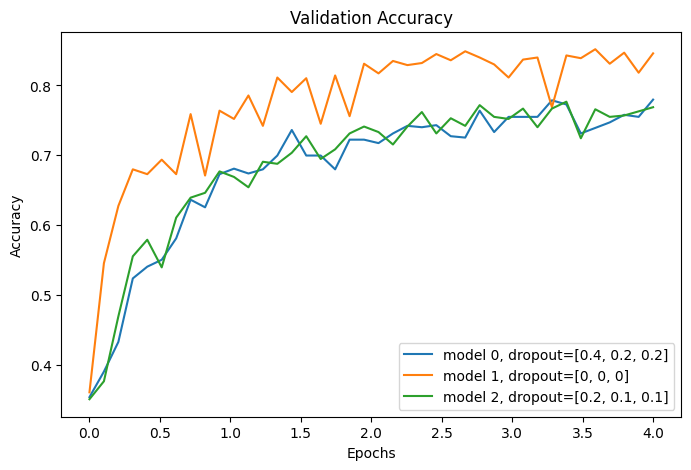

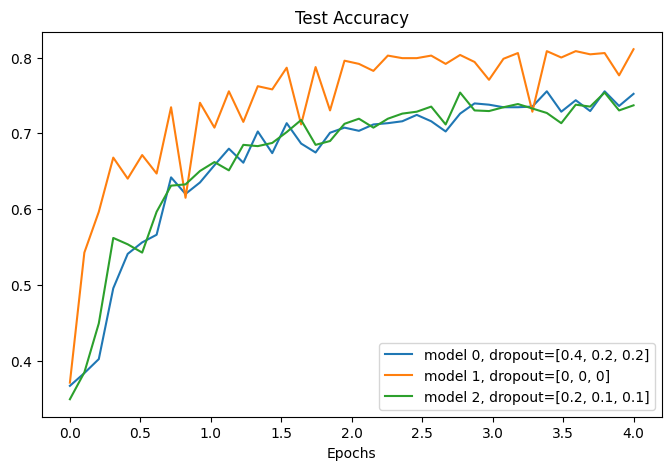

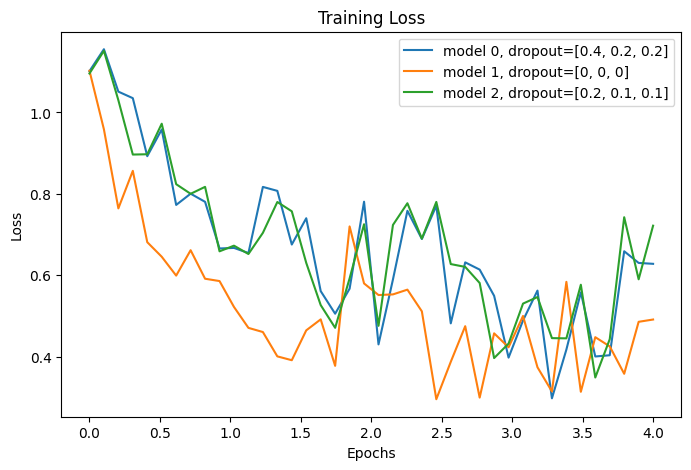

In [46]:
# Plot results from training
def plotAcc(models_label, models_acc):
    """ Plot validation accuracies to determine best model """

    plt.figure(figsize=(8, 5))
    plt.title("Validation Accuracy")
    for lab, accs in zip(models_label, models_acc):
        valacc = accs[:, 1]
        plt.plot(np.linspace(0, max_epochs, len(valacc)), valacc, label=lab)
    plt.legend()
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")

    plt.figure(figsize=(8, 5))
    plt.title("Test Accuracy")
    for lab, accs in zip(models_label, models_acc):
        valacc = accs[:, 2]
        plt.plot(np.linspace(0, max_epochs, len(valacc)), valacc, label=lab)
    plt.legend()
    plt.xlabel("Epochs")


def plotLosses(models_label, models_losses):
    """ Plot validation accuracies to determine best model """

    plt.figure(figsize=(8, 5))
    plt.title("Training Loss")
    for lab, loss in zip(models_label, models_losses):
        plt.plot(np.linspace(0, max_epochs, len(loss)), loss, label=lab)
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    
    
def bestModelAcc(models_acc):
    """
    Prints test accuracy of best model
    Returns model that yields the best test accuracy
    """

    best_acc_idx = np.argmax([acc[-1, -1] for acc in models_acc])
    best_acc = models_acc[best_acc_idx][-1, -1]
    print(f"Accuracy of test set of best model (idx={best_acc_idx}): {best_acc*100:.1f}%")
    return best_acc 

# Plot
plotAcc(models_label, models_acc)
plotLosses(models_label, models_losses)
# Print accuracy
acc_best_FC = bestModelAcc(models_acc)